In [1]:
import xarray as xr
from products.plot_settings import METEOFRANCE_VAR_NAME,NASA_L3_VAR_NAME,NASA_PSEUDO_L3_VAR_NAME
from winter_year import WinterYear

wy = WinterYear(2023,2024)
analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/analyses/confusion_table'
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True)
analyses_dict = {METEOFRANCE_VAR_NAME: mf_metrics_ds, NASA_PSEUDO_L3_VAR_NAME: nasa_pseudo_l3_metrics_ds, NASA_L3_VAR_NAME: nasa_l3_metrics_ds}

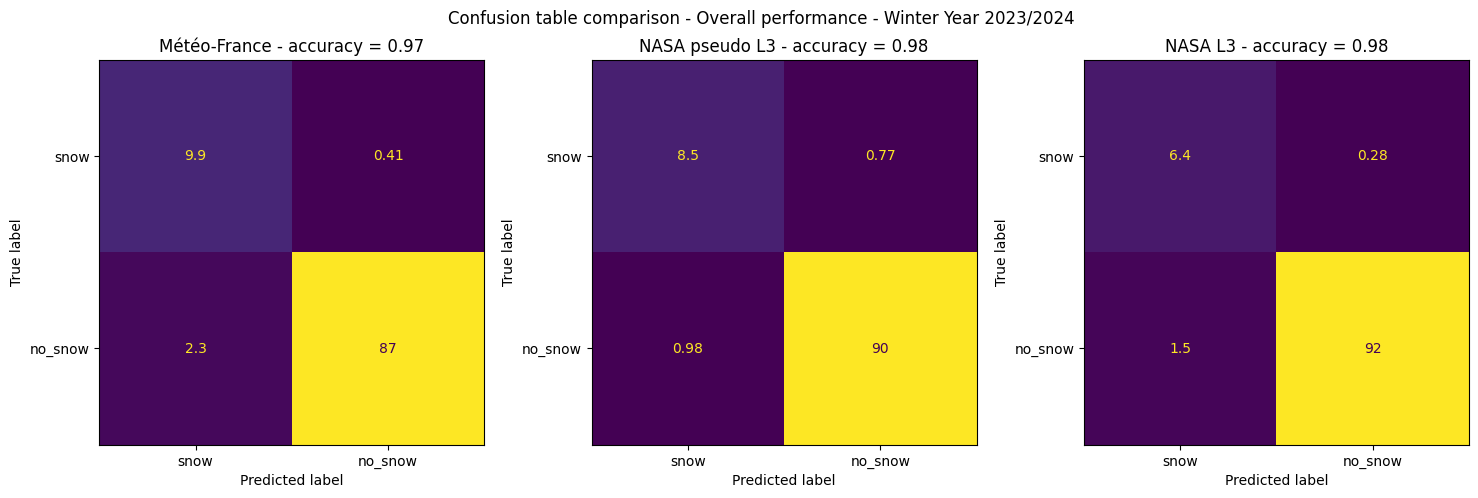

In [4]:
from postprocess.skill_scores import  plot_multiple_confusion_table
plot_multiple_confusion_table(metrics_dict=analyses_dict, title_complement=f"Overall performance - {str(wy)}")

percentage wrt to original domain 55.11346111478299
percentage wrt to original domain 54.815841358605596
percentage wrt to original domain 55.78317238520739


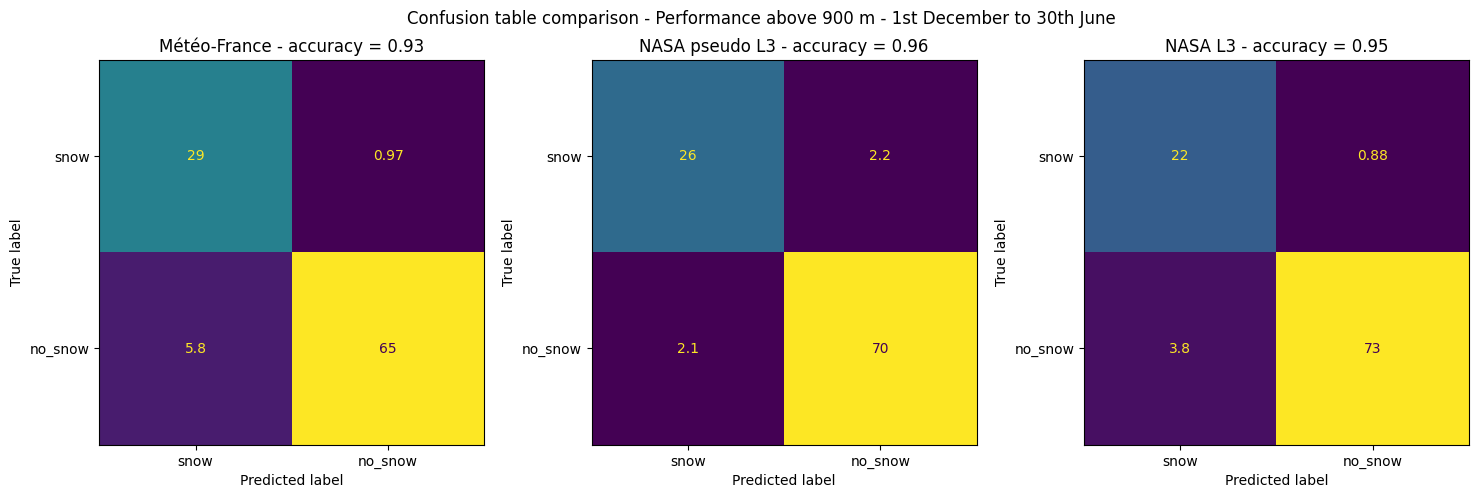

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2023-12','2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
for k, v in selection_dict.items():
    # data_vars selection doesn't matter
    print(f"percentage wrt to original domain for product {k}", v.data_vars['true_positive'].count().values/analyses_dict[k].data_vars['true_positive'].count().values*100)
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement=f'Performance above 900 m - 1st December to 30th June - {str(wy)}')

percentage wrt to original domain for product meteofrance_l3 26.187939815714785
percentage wrt to original domain for product nasa_pseudo_l3 25.370256365751725
percentage wrt to original domain for product nasa_l3 25.502074457273356


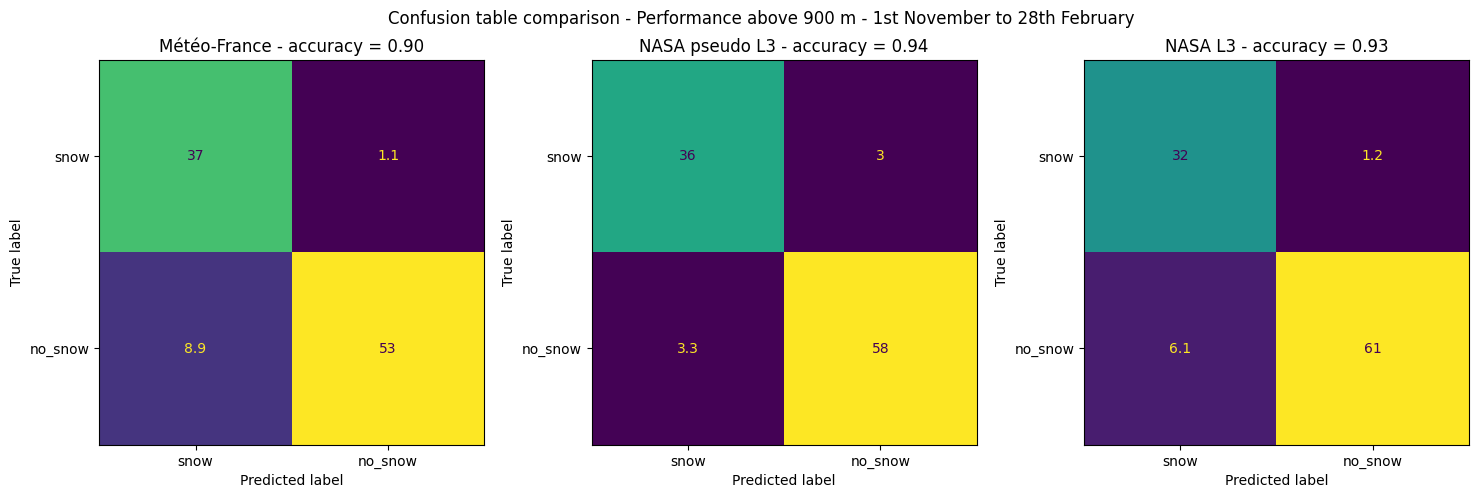

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2023-12','2024-02')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
for k, v in selection_dict.items():
    # data_vars selection doesn't matter
    print(f"percentage wrt to original domain for product {k}", v.data_vars['true_positive'].count().values/analyses_dict[k].data_vars['true_positive'].count().values*100)
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement=f'Performance above 900 m - 1st November to 28th February - {str(wy)}')

percentage wrt to original domain for product meteofrance_l3 21.570441792050595
percentage wrt to original domain for product nasa_pseudo_l3 22.724153922507192
percentage wrt to original domain for product nasa_l3 24.10515366128756


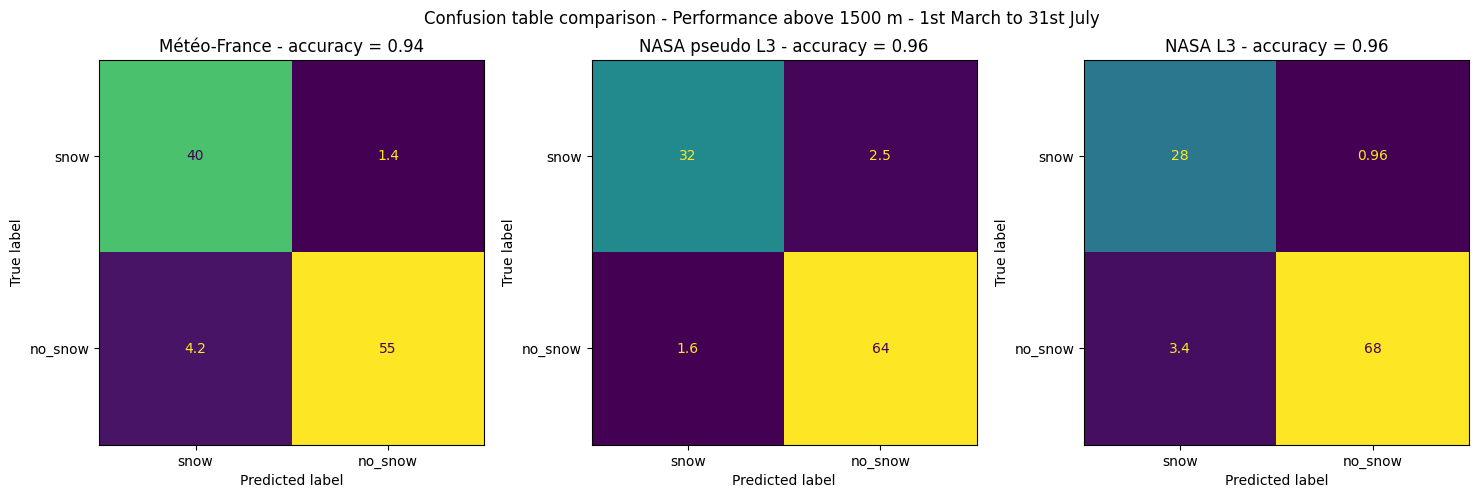

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2024-03','2024-07')).sel(altitude_bins=slice(2100,None)) for k,v in analyses_dict.items()}
for k, v in selection_dict.items():
    # data_vars selection doesn't matter
    print(f"percentage wrt to original domain for product {k}", v.data_vars['true_positive'].count().values/analyses_dict[k].data_vars['true_positive'].count().values*100)
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement=f'Performance above 1500 m - 1st March to 31st July- {str(wy)}')

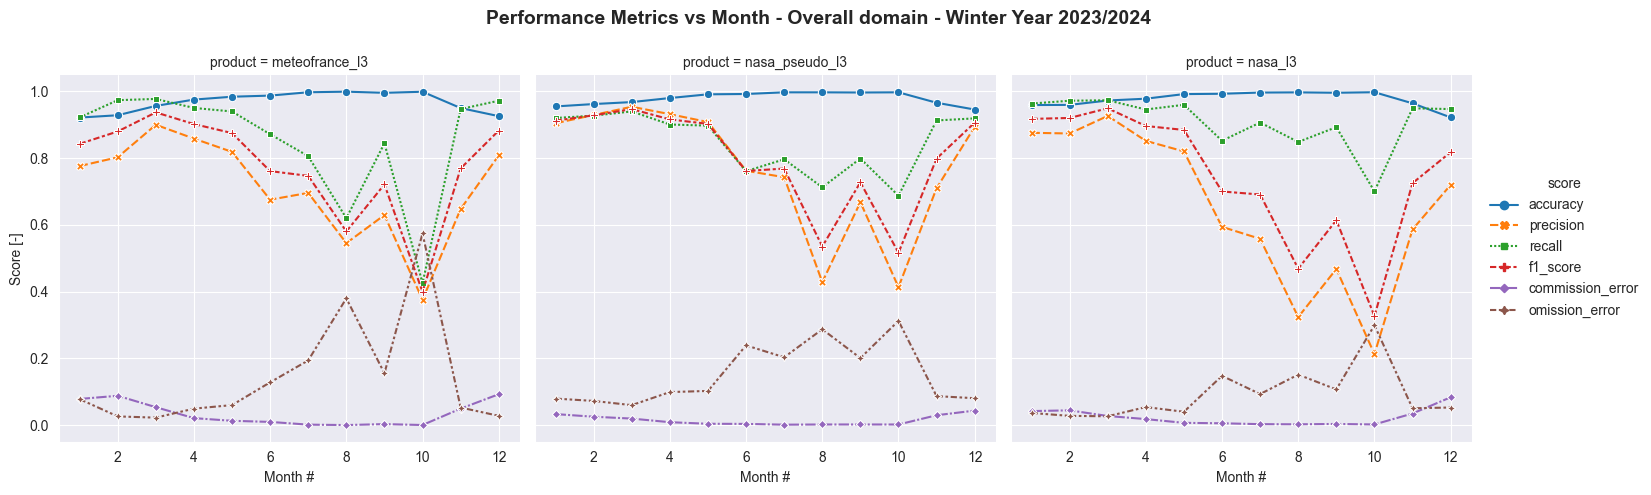

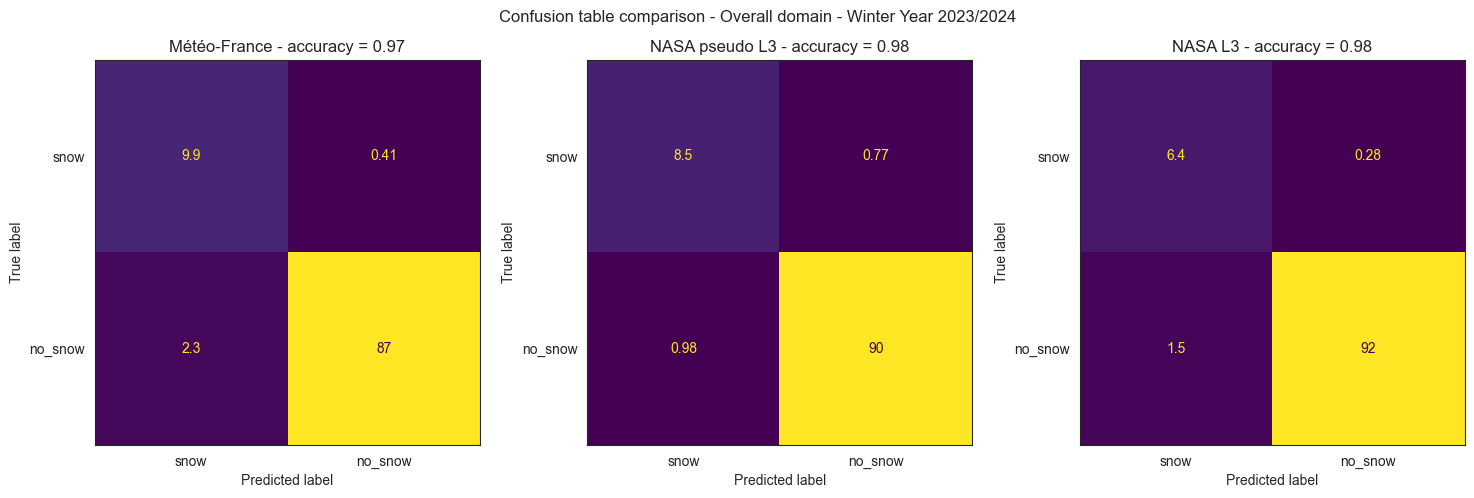

In [ ]:
from typing import Dict
import pandas as pd
from postprocess.skill_scores import compute_all_scores
import seaborn as sns
import numpy as np

selection_dict = {k: v for k,v in analyses_dict.items()}

def plot_multiple_scores_sns_month(metrics_dict: Dict[str, xr.Dataset],variable: str, xlabel:str,title_complement: str):
    results = []
    for  metrics_ds in metrics_dict.values():
        results.append(metrics_ds.groupby(variable).map(compute_all_scores))
    results = xr.concat(results, pd.Index(list(metrics_dict.keys()), name="product")).to_dataframe()
    results = results.reset_index([variable[-5:], 'product'])
    results = results.melt(id_vars=['product', variable[-5:]], var_name='score', value_name='value')
    sns.set_style("darkgrid")
    g = sns.relplot(results,x=variable[-5:],hue="score",y='value',col='product', kind='line',style='score',markers=True, col_wrap=np.min([len(metrics_dict),4]))
    g.figure.suptitle(f"Performance Metrics vs {title_complement}", fontsize=14, fontweight="bold")
    # Adjust layout to make space for the title
    g.figure.subplots_adjust(top=0.85)
    g.set_axis_labels(xlabel, "Score [-]")


plot_multiple_scores_sns_month(metrics_dict=selection_dict, variable='time.month', xlabel='Month #',title_complement=f'Month - Overall domain - {str(wy)}')
sns.set_style("white")
plot_multiple_confusion_table(selection_dict, f'Overall domain - {str(wy)}')

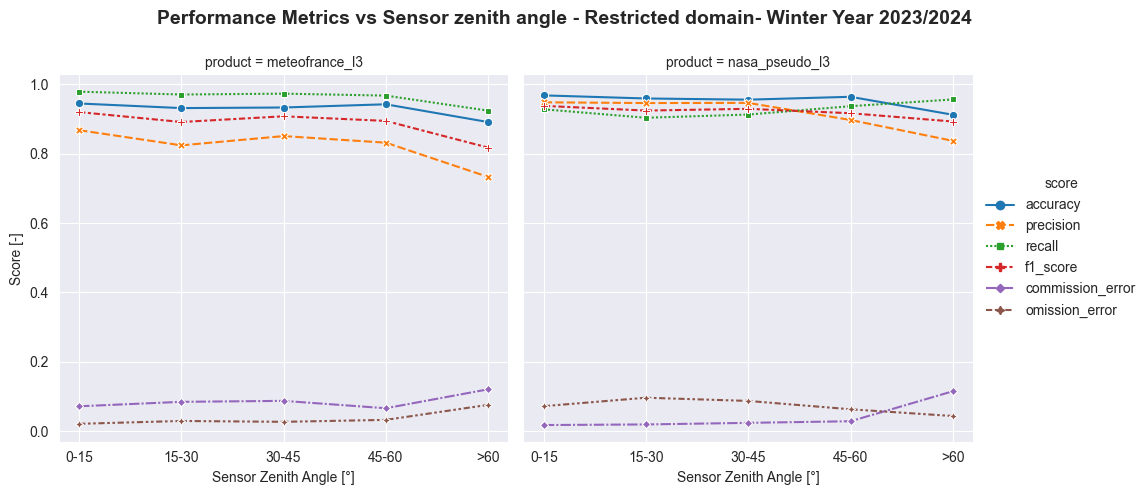

In [7]:
from postprocess.skill_scores import plot_multiple_scores_sns


selection_dict = {k: v.sel(altitude_bins=slice(1500,None)).sel(time=slice('2023-12','2024-06')) for k,v in analyses_dict.items()}
selection_dict.pop('nasa_l3')
selection_dict = {k: v.sel(sensor_zenith_bins=slice(None, 75)).assign_coords({'sensor_zenith_bins': ['0-15', '15-30', '30-45', '45-60', '>60']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sensor_zenith_bins', xlabel='Sensor Zenith Angle [°]',title_complement=f'Sensor zenith angle - Restricted domain- {str(wy)}')

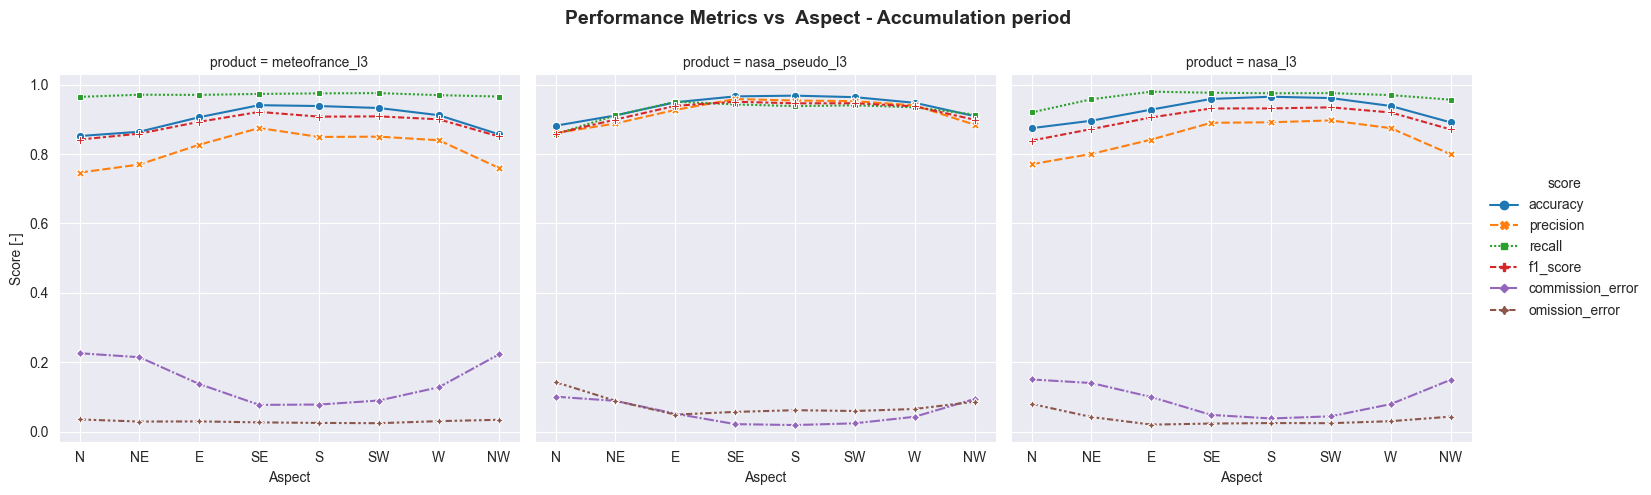

In [ ]:
from reductions.statistics_base import EvaluationVsHighResBase
selection_dict = {k: v.sel(time=slice('2023-12','2024-02')).sel(altitude_bins=slice(1500, None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'aspect_bins':pd.CategoricalIndex(data=EvaluationVsHighResBase.aspect_bins().labels, categories=EvaluationVsHighResBase.aspect_bins().labels, ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='aspect_bins', xlabel='Aspect',title_complement=f'Aspect - Accumulation period- {str(wy)}')


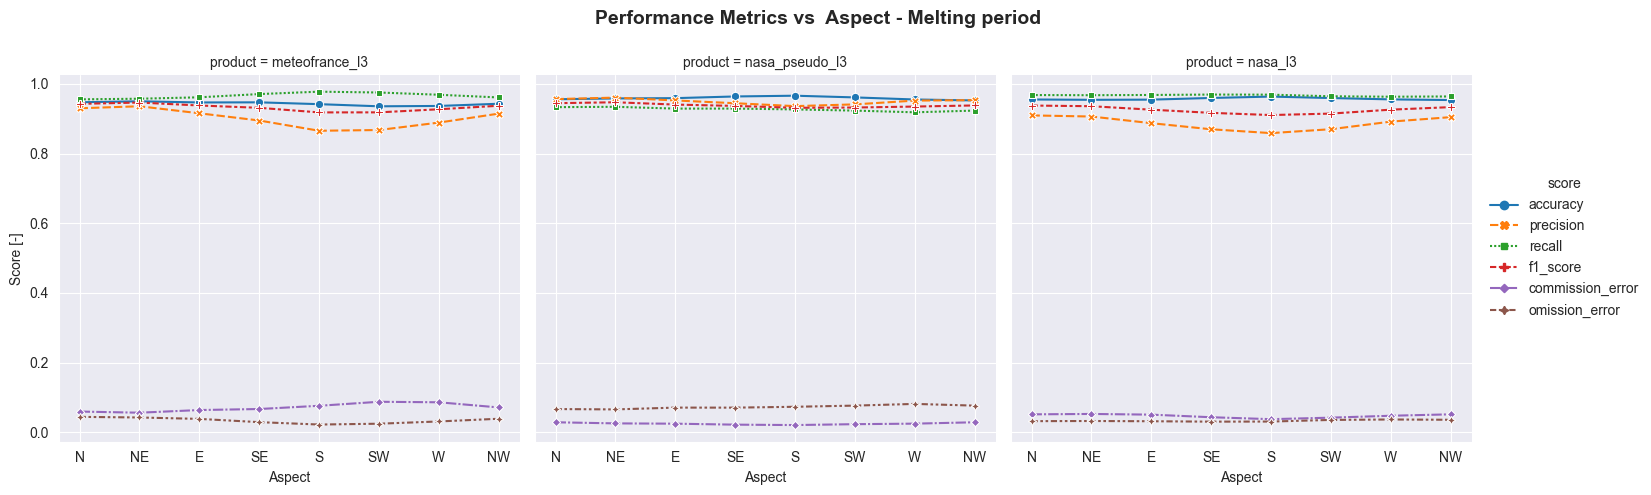

In [ ]:
from reductions.statistics_base import EvaluationVsHighResBase
selection_dict = {k: v.sel(time=slice('2024-03','2024-07')).sel(altitude_bins=slice(2100, None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'aspect_bins':pd.CategoricalIndex(data=EvaluationVsHighResBase.aspect_bins().labels, categories=EvaluationVsHighResBase.aspect_bins().labels, ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='aspect_bins', xlabel='Aspect',title_complement=f'Aspect - Melting period - {str(wy)}')


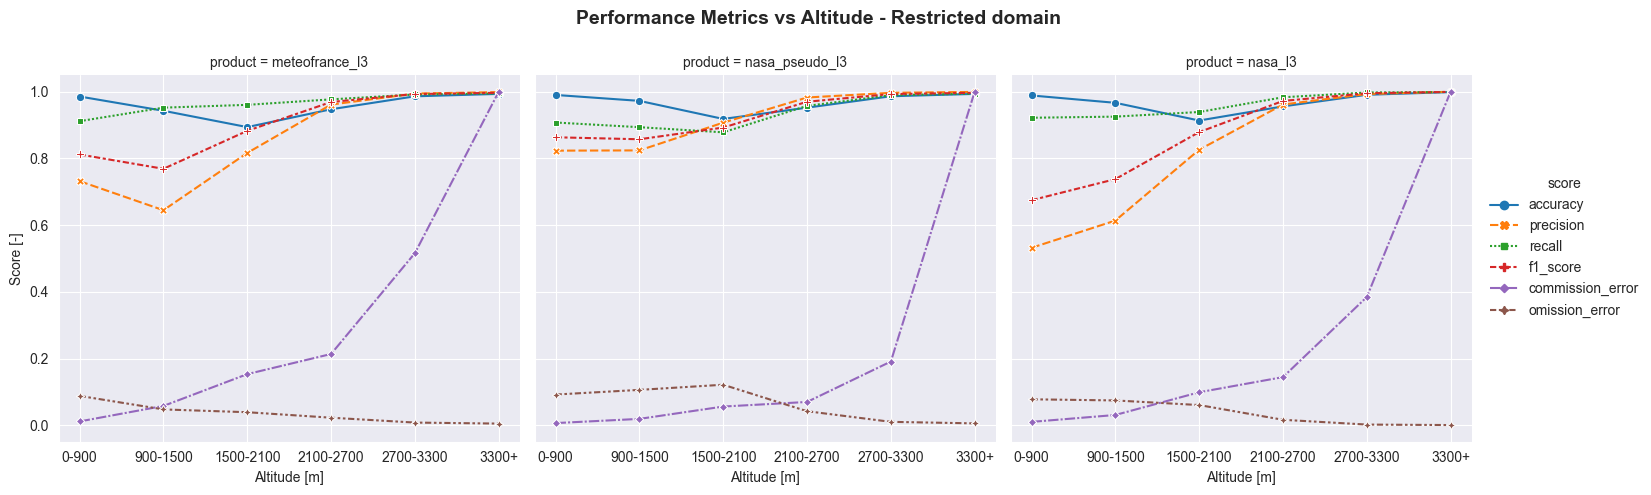

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'altitude_bins': pd.CategoricalIndex(data=['0-900', '900-1500','1500-2100','2100-2700','2700-3300', '3300+'], categories=['0-900', '900-1500','1500-2100','2100-2700','2700-3300', '3300+'], ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='altitude_bins', xlabel='Altitude [m]',title_complement=f'Altitude - Restricted domain- {str(wy)}')


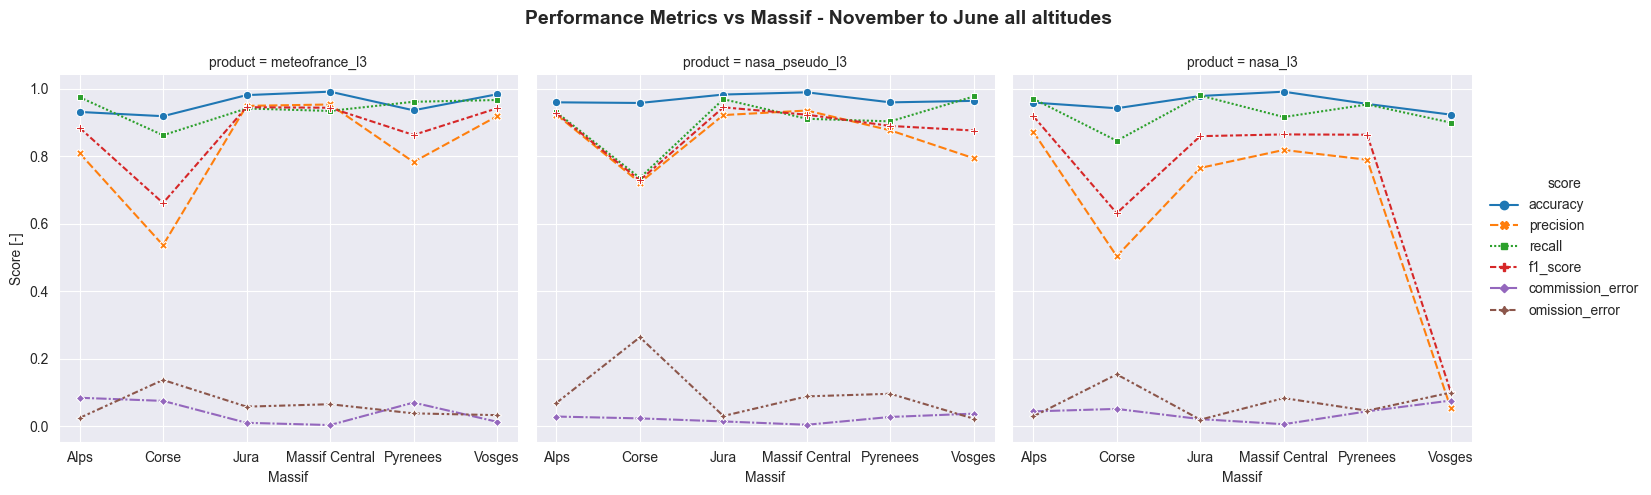

In [ ]:
from reductions.statistics_base import EvaluationVsHighResBase
selection_dict = {k: v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'sub_roi': ['','Alps', 'Pyrenees', 'Corse', 'Massif Central', 'Jura', 'Vosges']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sub_roi', xlabel='Massif',title_complement=f'Massif - November to June all altitudes - {str(wy)}')


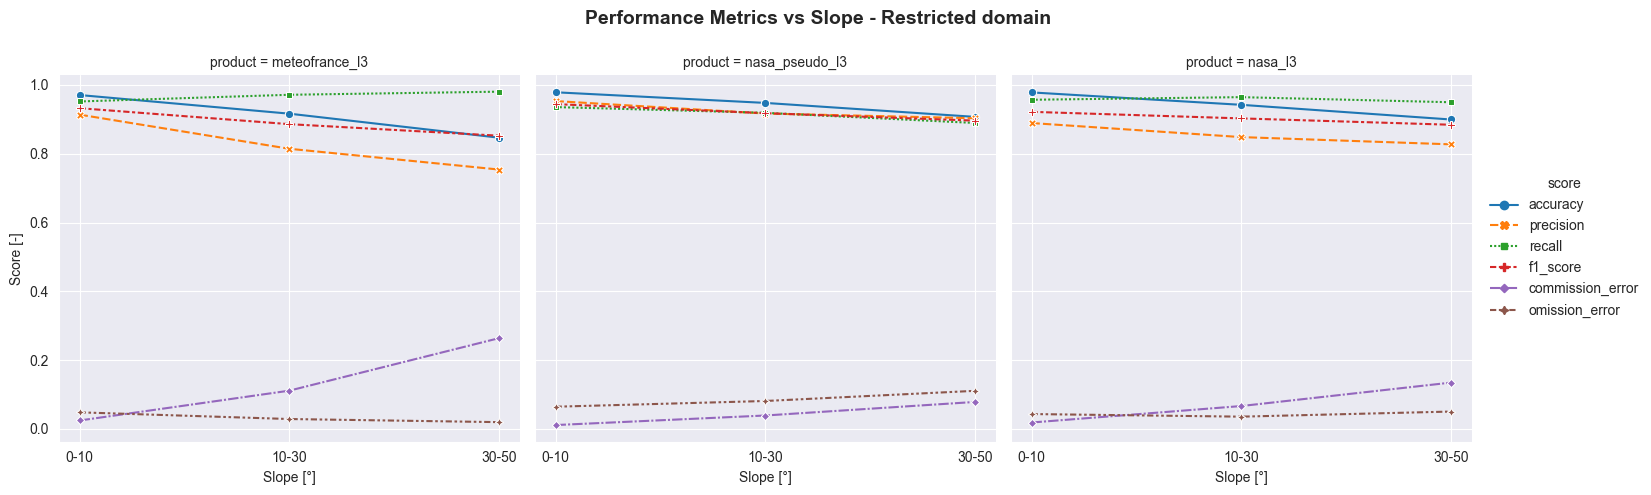

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.sel(slope_bins=slice(None, 50)).assign_coords({'slope_bins': ['0-10', '10-30', '30-50']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='slope_bins', xlabel='Slope [°]',title_complement=f'Slope - Restricted domain - {str(wy)}')


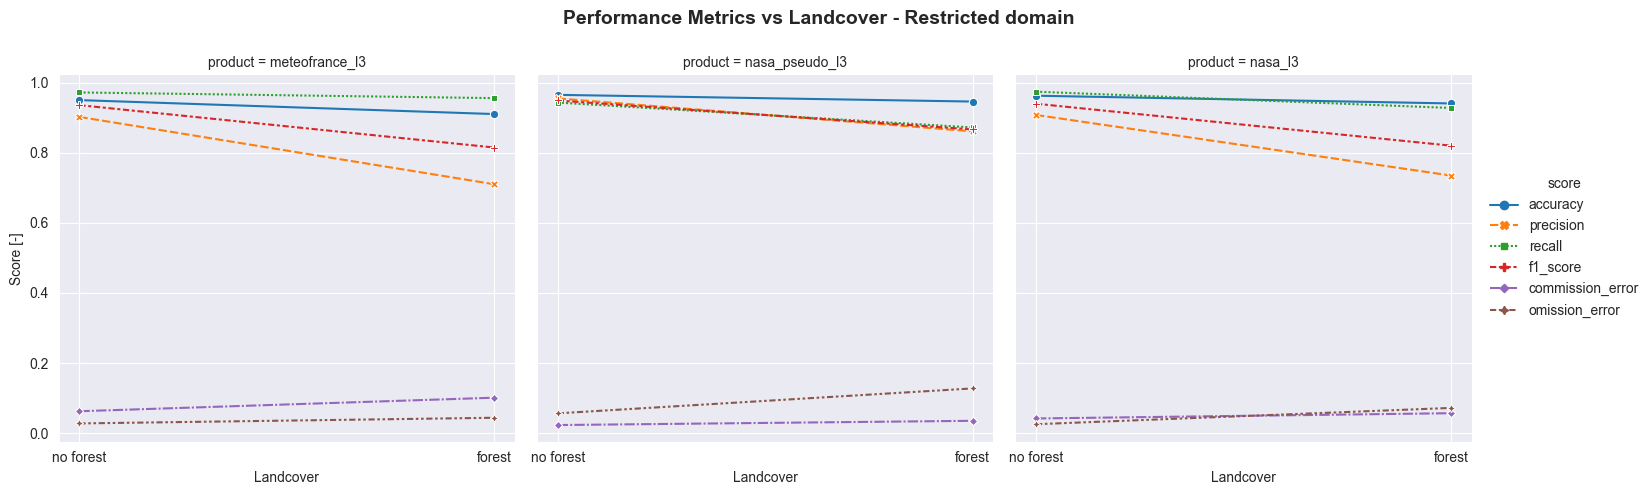

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'forest_mask': ['no forest', 'forest']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='forest_mask', xlabel='Landcover',title_complement=f'Landcover - Restricted domain - {str(wy)}')

In [2]:
# from postprocess.skill_scores import compute_results_df, fancy_table
import pandas as pd

from postprocess.skill_scores import compute_results_df, fancy_table_skill_scores


selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("General performance")
fancy_table_skill_scores(df)



General performance


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.93,0.83,0.97,0.89,0.08,0.03
nasa_pseudo_l3,0.96,0.92,0.92,0.92,0.03,0.08
nasa_l3,0.95,0.85,0.96,0.91,0.05,0.04


In [3]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-02')).sel(aspect_bins=['NE','N','NW']).sel(slope_bins=slice(30,None)).sel(forest_mask=1,drop=True).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("Worst case scenario: accumulation period, north slopes >10°, forest")
fancy_table_skill_scores(df)

Worst case scenario: accumulation period, north slopes >10°, forest


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.75,0.58,0.97,0.73,0.36,0.03
nasa_pseudo_l3,0.84,0.78,0.78,0.78,0.13,0.22
nasa_l3,0.83,0.67,0.89,0.77,0.20,0.11


In [4]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-02')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("General accumulation scenario: period, all slopes")
fancy_table_skill_scores(df)

General accumulation scenario: period, all slopes


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.90,0.81,0.97,0.88,0.14,0.03
nasa_pseudo_l3,0.94,0.92,0.92,0.92,0.05,0.08
nasa_l3,0.93,0.84,0.96,0.90,0.09,0.04


In [5]:
selection_dict = {k: v.sel(time=slice('2024-03', '2024-07')).sel(altitude_bins=slice(2100,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("General ablation scenario: ablation period, all slopes")
fancy_table_skill_scores(df)

General ablation scenario: ablation period, all slopes


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.94,0.90,0.96,0.93,0.07,0.04
nasa_pseudo_l3,0.96,0.95,0.93,0.94,0.02,0.07
nasa_l3,0.96,0.89,0.97,0.93,0.05,0.03


In [6]:
selection_dict = {k: v.sel(time=slice('2024-03', '2024-07')).sel(aspect_bins=['SE','S','SW']).sel(slope_bins=slice(None,40)).sel(forest_mask=0,drop=True).sel(altitude_bins=slice(2100,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("Best case scenario: ablation period, south slopes <30°, no forest")
fancy_table_skill_scores(df)

Best case scenario: ablation period, south slopes <30°, no forest


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.95,0.91,0.98,0.94,0.06,0.02
nasa_pseudo_l3,0.97,0.96,0.93,0.95,0.02,0.07
nasa_l3,0.97,0.89,0.97,0.93,0.04,0.03
